# The Wilson-Cowan model (Whole-brain Model)

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy
import neurolib.utils.devutils as du

from neurolib.models.wc import WCModel
import pingouin as pg

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func
from neurolib.utils.loadData import Dataset
from scipy.io import loadmat
from neurolib.utils.loadData import filterSubcortical
import seaborn as sns

# a nice color map
plt.rcParams['image.cmap'] = 'magma'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
data_path = "/Users/pamirozsuna/Documents/pamir_ma/data/COBRE/SCZ-FC-modelling"

In [3]:
def averageMat(Mat):
    avMat = np.zeros((94,94))
    for i in range(len(Mat)):
        avMat = avMat + Mat[i]
    avMat = avMat/len(Mat)
    return avMat

In [5]:
C_data = np.load(data_path+"/AvgCmatrixHC.npy")
D_data = np.load(data_path+"/AvgDmatrixHC.npy")

C_data_scz = np.load(data_path+"/AvgCmatrixSCZ.npy")
D_data_scz = np.load(data_path+"/AvgDmatrixSCZ.npy")

In [6]:
Cmat_tmp = averageMat(C_data)
Dmat_tmp = averageMat(D_data)

Cmat_tmp_scz = averageMat(C_data_scz)
Dmat_tmp_scz = averageMat(D_data_scz)

In [7]:
Cmat = filterSubcortical(Cmat_tmp)
Dmat = filterSubcortical(Dmat_tmp)

Cmat_scz = filterSubcortical(Cmat_tmp_scz)
Dmat_scz = filterSubcortical(Dmat_tmp_scz)

In [8]:
FC_data = np.load(data_path+"/AvgFmatrixHC.npy")
timeseries = np.load(data_path+"/AvgTmatrixHC.npy")

FC_data_scz = np.load(data_path+"/AvgFmatrixSCZ.npy")
timeseries_scz = np.load(data_path+"/AvgTmatrixSCZ.npy")

In [9]:
FC_tmp = averageMat(FC_data)
FCs = filterSubcortical(FC_tmp)

FC_tmp_scz = averageMat(FC_data_scz)
FCs_scz = filterSubcortical(FC_tmp_scz)

In [10]:
subjects = []
for i in FC_data:
    subjects.append(filterSubcortical(i))
    
gbc_subjects = []
for i in subjects:
    gbc_subjects.append(np.mean(i))
    
subjects_scz = []
for i in FC_data_scz:
    subjects_scz.append(filterSubcortical(i))
    
gbc_subjects_scz = []
for i in subjects_scz:
    gbc_subjects_scz.append(np.mean(i))

In [11]:
np.std(gbc_subjects)

0.14492626097519337

In [12]:
np.std(gbc_subjects_scz)

0.15174650846640597

In [14]:
res = pg.ttest(gbc_subjects, gbc_subjects_scz, correction=False)
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.678573,70,two-sided,0.009207,"[0.02, 0.17]",0.631346,4.881,0.752287


In [30]:
wc = WCModel(Cmat = Cmat, Dmat = Dmat, seed=23)
wc.params['duration'] = 40*1000
wc.params['exc_ext'] = 0.45
wc.params['c_excinh'] = 10.33
wc.params['c_inhexc'] = 9.67
wc.params['c_inhinh'] = 0
wc.params['K_gl'] = 1.84
wc.params['sigma_ou'] = 4.28e-05
wc.params['dt'] = 0.1

wc.run(bold = True)
gbc_model = np.mean(func.fc(wc.BOLD.BOLD[:, wc.BOLD.t_BOLD>10000]))
print(gbc_model)

0.4198337671756288


In [21]:
wc_scz = WCModel(Cmat = Cmat_scz, Dmat = Dmat_scz, seed=12)
wc_scz.params['duration'] = 40*1000
wc_scz.params['exc_ext'] = 0.5
wc_scz.params['c_excinh'] = 10.0
wc_scz.params['c_inhexc'] = 8.67
wc_scz.params['c_inhinh'] = 0.22
wc_scz.params['K_gl'] = 1.84
wc_scz.params['sigma_ou'] = 4.28e-05

wc_scz.run(bold = True)
gbc_model = np.mean(func.fc(wc_scz.BOLD.BOLD[:, wc_scz.BOLD.t_BOLD>10000]))
print(gbc_model)

0.33783750503458165


In [36]:
import graph_measures.network as net
mat = func.fc(wc.BOLD.BOLD[:, wc.BOLD.t_BOLD>10000])
mat_scz = func.fc(wc_scz.BOLD.BOLD[:, wc_scz.BOLD.t_BOLD>10000])
mat_emp_scz = FCs_scz

for i in range(0,80):
    for j in range(0,80):
        if mat[i][j] < 0:
            mat[i][j] = 0
        if mat_scz[i][j] < 0:
            mat_scz[i][j] = 0
        if FCs_scz[i][j] < 0:
            mat_emp_scz[i][j] = 0
    

G = net.network(Adjacency_Matrix=mat)
print(G.GlobalEfficiency())
print(G.char_path())
print(G.ClusteringCoefficient())
print(G.Transitivity())

G_emp = net.network(Adjacency_Matrix=FCs)
print(G_emp.GlobalEfficiency())
print(G_emp.char_path())
print(G_emp.ClusteringCoefficient())
print(G_emp.Transitivity())

G_scz = net.network(Adjacency_Matrix=mat_scz)
print(G_scz.GlobalEfficiency())
print(G_scz.char_path())
print(G_scz.ClusteringCoefficient())
print(G_scz.Transitivity())

G_emp_scz = net.network(Adjacency_Matrix=mat_emp_scz)
print(G_emp_scz.GlobalEfficiency())
print(G_emp_scz.char_path())
print(G_emp_scz.ClusteringCoefficient())
print(G_emp_scz.Transitivity())

[array(13.38129464)]
{'node_avg_dist': 0     1.893635
1     1.968738
2     2.558629
3     2.351350
4     2.411321
        ...   
75    1.949433
76    2.483685
77    4.557355
78    3.425935
79    3.973502
Length: 80, dtype: float64, 'characteristic_path': 2.3359723098388847}
[4.932256082709978]
[2.4912954869807455]
[array(4.23761962)]
{'node_avg_dist': 0     2.196670
1     2.364624
2     2.346594
3     2.257482
4     2.281356
        ...   
75    1.981444
76    4.100782
77    3.213311
78    2.863441
79    2.483360
Length: 80, dtype: float64, 'characteristic_path': 2.7468480242448328}
[3.876308976466426]
[3.003782727538218]
[array(17.05568392)]
{'node_avg_dist': 0     2.673503
1     2.803883
2     2.656678
3     2.918895
4     2.463206
        ...   
75    2.595398
76    2.335004
77    2.528240
78    2.249846
79    2.177868
Length: 80, dtype: float64, 'characteristic_path': 2.7011791576619126}
[7.421127044057434]
[3.3760200556086377]
[array(8.72906576)]
{'node_avg_dist': 0     2.750207
1

In [26]:
emp_labels = ['PreCG.L', 'PreCG.R', 'SFG.L', 'SFG.R', 'MFG.L', 'MFG.R',
       'IFGoperc.L', 'IFGoperc.R', 'IFGtriang.L', 'IFGtriang.R',
       'IFGorb.L', 'IFGorb.R', 'ROL.L', 'ROL.R', 'SMA.L', 'SMA.R',
       'OLF.L', 'OLF.R', 'SFGmed.L', 'SFGmed.R', 'PFCventmed.L',
       'PFCventmed.R', 'REC.L', 'REC.R', 'OFCmed.L', 'OFCmed.R',
       'OFCant.L', 'OFCant.R', 'OFCpos.L', 'OFCpos.R', 'OFClat.L',
       'OFClat.R', 'INS.L', 'INS.R', 'ACC.L', 'ACC.R', 'MCC.L', 'MCC.R',
       'PCC.L', 'PCC.R', 'CAL.L', 'CAL.R', 'CUN.L', 'CUN.R', 'LING.L',
       'LING.R', 'SOG.L', 'SOG.R', 'MOG.L', 'MOG.R', 'IOG.L', 'IOG.R',
       'FFG.L', 'FFG.R', 'PoCG.L', 'PoCG.R', 'SPG.L', 'SPG.R', 'IPG.L',
       'IPG.R', 'SMG.L', 'SMG.R', 'ANG.L', 'ANG.R', 'PCUN.L', 'PCUN.R',
       'PCL.L', 'PCL.R', 'HES.L', 'HES.R', 'STG.L', 'STG.R', 'TPOsup.L',
       'TPOsup.R', 'MTG.L', 'MTG.R', 'TPOmid.L', 'TPOmid.R', 'ITG.L',
       'ITG.R']

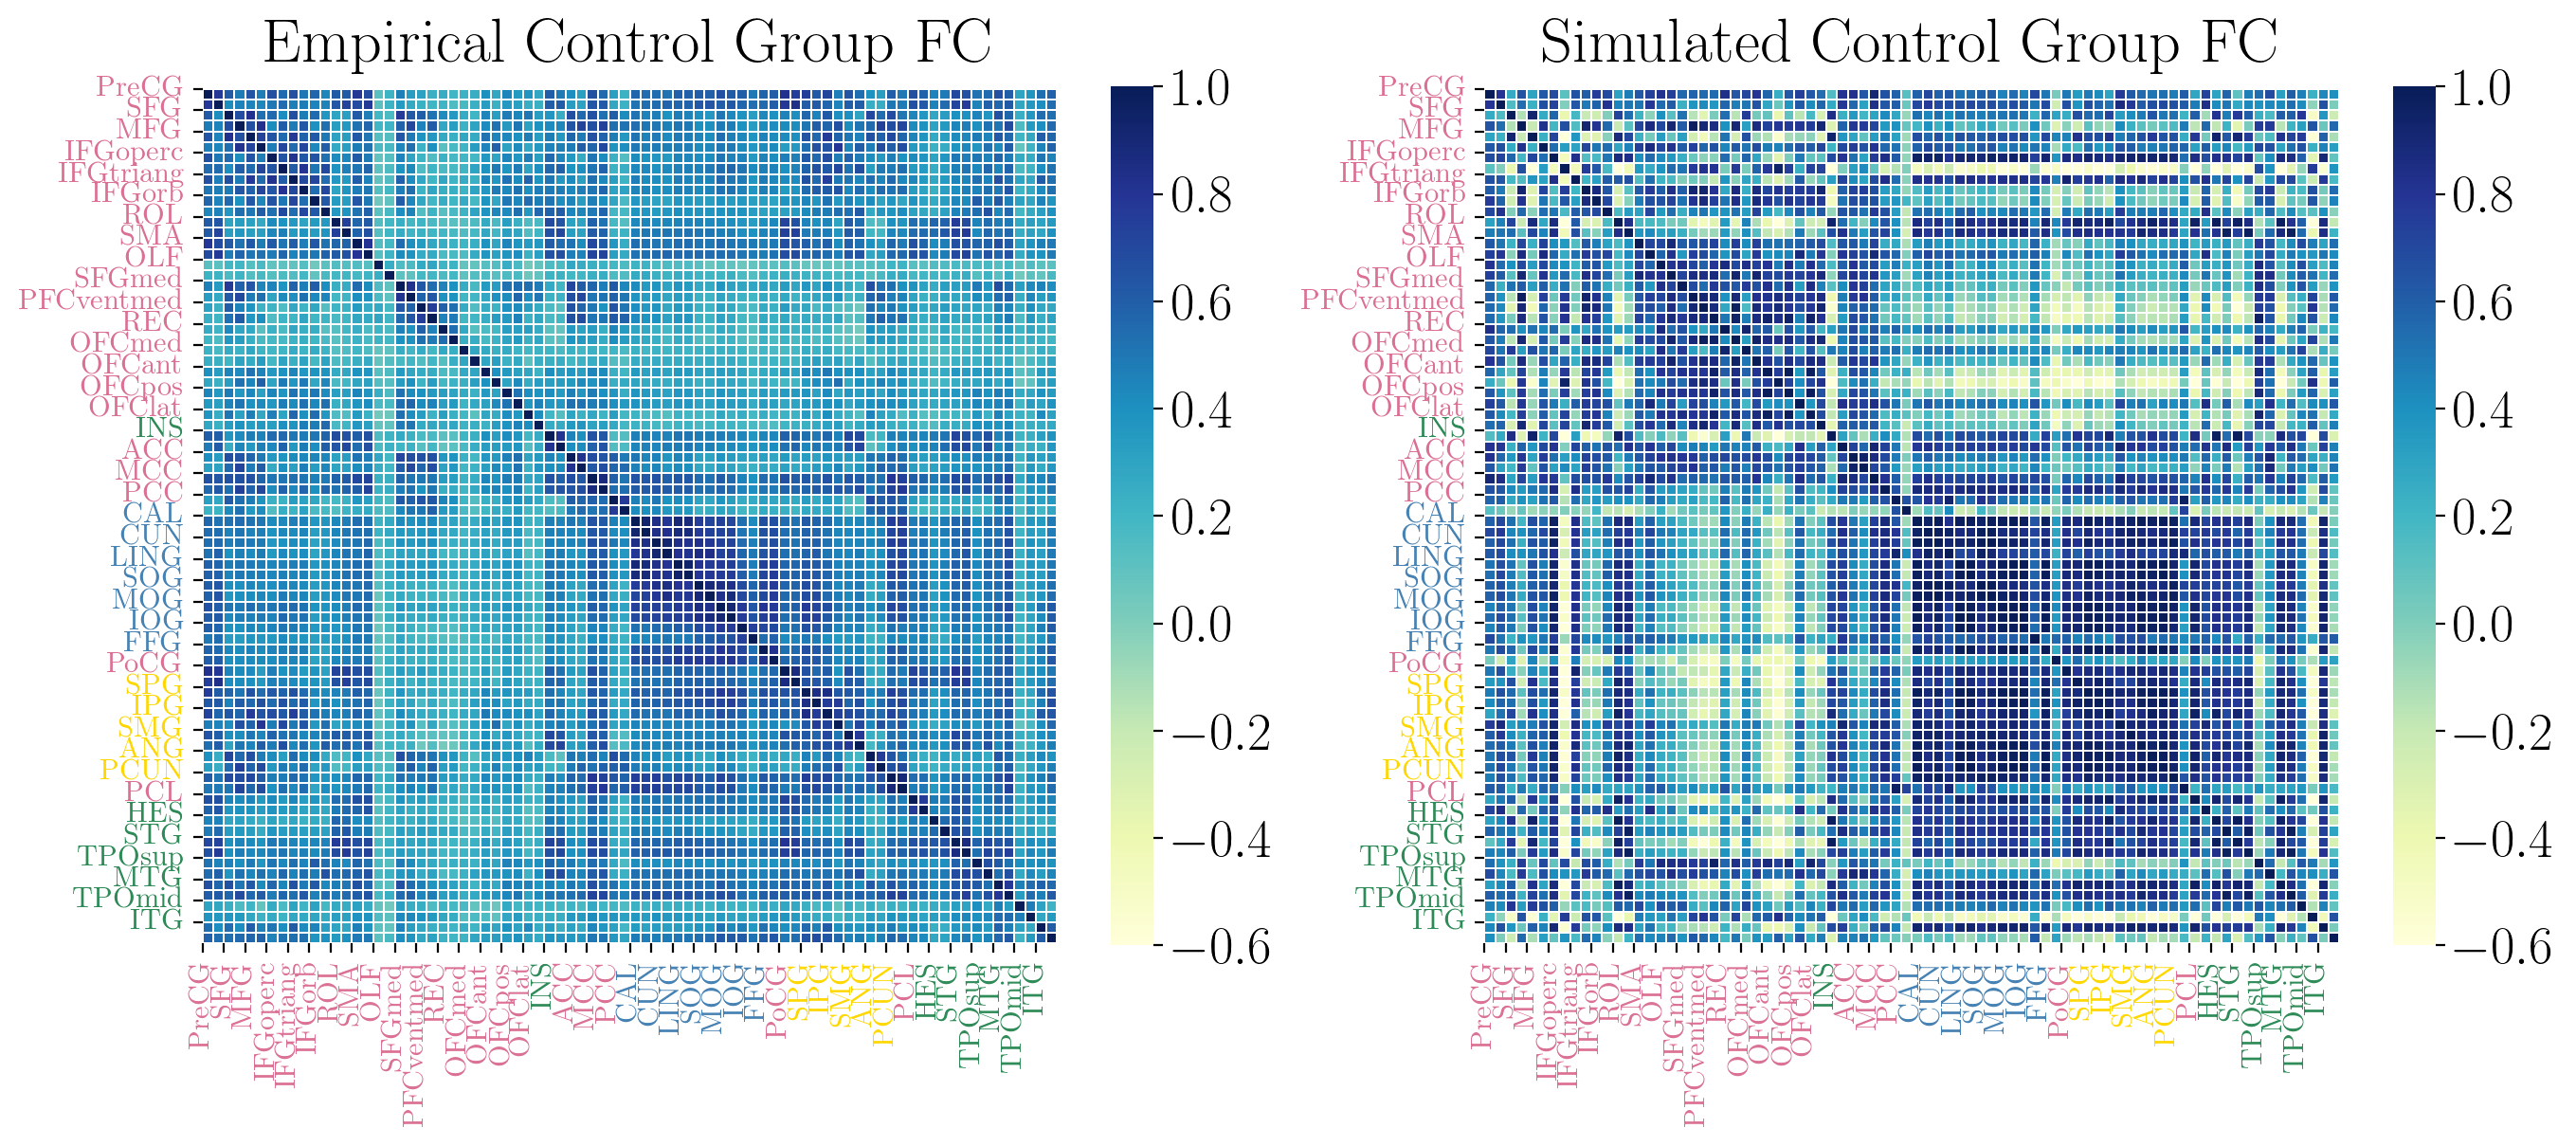

In [27]:
import neurolib.utils.functions as func

# Plot Empirical and simulated connectivity matrix
fig, ax = plt.subplots(1,2, figsize=(16,10))
fig.set_facecolor('w') 
sns.heatmap(FCs, square=True, ax=ax[0], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .6}, vmin=-0.6, vmax=1)
ax[0].set_title('Empirical Control Group FC',pad=10,  size=24);
sns.heatmap(func.fc(wc.BOLD.BOLD[:, wc.BOLD.t_BOLD>10000]), square=True, ax=ax[1], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .6},vmin=-0.6, vmax=1)
ax[1].set_title('Simulated Control Group FC',pad=10,  size=24);
ticks = [tick[:-2] for tick in emp_labels[::2]]
for axs in ax:
    axs.set_xticks(np.arange(0,80,2)); axs.set_yticks(np.arange(0,80,2))    
    axs.set_xticklabels(ticks, rotation=90, fontsize=11); axs.set_yticklabels(ticks, rotation=0, fontsize=11);
    
ax[0].get_xticklabels()[0].set_color("palevioletred")
ax[0].get_xticklabels()[1].set_color("palevioletred")
ax[0].get_xticklabels()[2].set_color("palevioletred")
ax[0].get_xticklabels()[3].set_color("palevioletred")
ax[0].get_xticklabels()[4].set_color("palevioletred")
ax[0].get_xticklabels()[5].set_color("palevioletred")
ax[0].get_xticklabels()[6].set_color("palevioletred")
ax[0].get_xticklabels()[7].set_color("palevioletred")
ax[0].get_xticklabels()[8].set_color("palevioletred")
ax[0].get_xticklabels()[9].set_color("palevioletred")
ax[0].get_xticklabels()[10].set_color("palevioletred")
ax[0].get_xticklabels()[11].set_color("palevioletred")
ax[0].get_xticklabels()[12].set_color("palevioletred")
ax[0].get_xticklabels()[13].set_color("palevioletred")
ax[0].get_xticklabels()[14].set_color("palevioletred")
ax[0].get_xticklabels()[15].set_color("palevioletred")
ax[0].get_xticklabels()[17].set_color("palevioletred")
ax[0].get_xticklabels()[18].set_color("palevioletred")
ax[0].get_xticklabels()[19].set_color("palevioletred")
ax[0].get_xticklabels()[27].set_color("palevioletred")
ax[0].get_xticklabels()[33].set_color("palevioletred")
ax[0].get_yticklabels()[0].set_color("palevioletred")
ax[0].get_yticklabels()[1].set_color("palevioletred")
ax[0].get_yticklabels()[2].set_color("palevioletred")
ax[0].get_yticklabels()[3].set_color("palevioletred")
ax[0].get_yticklabels()[4].set_color("palevioletred")
ax[0].get_yticklabels()[5].set_color("palevioletred")
ax[0].get_yticklabels()[6].set_color("palevioletred")
ax[0].get_yticklabels()[7].set_color("palevioletred")
ax[0].get_yticklabels()[8].set_color("palevioletred")
ax[0].get_yticklabels()[9].set_color("palevioletred")
ax[0].get_yticklabels()[10].set_color("palevioletred")
ax[0].get_yticklabels()[11].set_color("palevioletred")
ax[0].get_yticklabels()[12].set_color("palevioletred")
ax[0].get_yticklabels()[13].set_color("palevioletred")
ax[0].get_yticklabels()[14].set_color("palevioletred")
ax[0].get_yticklabels()[15].set_color("palevioletred")
ax[0].get_yticklabels()[17].set_color("palevioletred")
ax[0].get_yticklabels()[18].set_color("palevioletred")
ax[0].get_yticklabels()[19].set_color("palevioletred")
ax[0].get_yticklabels()[27].set_color("palevioletred")
ax[0].get_yticklabels()[33].set_color("palevioletred")

ax[0].get_xticklabels()[16].set_color("seagreen")
ax[0].get_xticklabels()[34].set_color("seagreen")
ax[0].get_xticklabels()[35].set_color("seagreen")
ax[0].get_xticklabels()[36].set_color("seagreen")
ax[0].get_xticklabels()[37].set_color("seagreen")
ax[0].get_xticklabels()[38].set_color("seagreen")
ax[0].get_xticklabels()[39].set_color("seagreen")

ax[0].get_yticklabels()[16].set_color("seagreen")
ax[0].get_yticklabels()[34].set_color("seagreen")
ax[0].get_yticklabels()[35].set_color("seagreen")
ax[0].get_yticklabels()[36].set_color("seagreen")
ax[0].get_yticklabels()[37].set_color("seagreen")
ax[0].get_yticklabels()[38].set_color("seagreen")
ax[0].get_yticklabels()[39].set_color("seagreen")

ax[0].get_xticklabels()[20].set_color("steelblue")
ax[0].get_xticklabels()[21].set_color("steelblue")
ax[0].get_xticklabels()[22].set_color("steelblue")
ax[0].get_xticklabels()[23].set_color("steelblue")
ax[0].get_xticklabels()[24].set_color("steelblue")
ax[0].get_xticklabels()[25].set_color("steelblue")
ax[0].get_xticklabels()[26].set_color("steelblue")

ax[0].get_yticklabels()[20].set_color("steelblue")
ax[0].get_yticklabels()[21].set_color("steelblue")
ax[0].get_yticklabels()[22].set_color("steelblue")
ax[0].get_yticklabels()[23].set_color("steelblue")
ax[0].get_yticklabels()[24].set_color("steelblue")
ax[0].get_yticklabels()[25].set_color("steelblue")
ax[0].get_yticklabels()[26].set_color("steelblue")

ax[0].get_xticklabels()[28].set_color("gold")
ax[0].get_xticklabels()[29].set_color("gold")
ax[0].get_xticklabels()[30].set_color("gold")
ax[0].get_xticklabels()[31].set_color("gold")
ax[0].get_xticklabels()[32].set_color("gold")

ax[0].get_yticklabels()[28].set_color("gold")
ax[0].get_yticklabels()[29].set_color("gold")
ax[0].get_yticklabels()[30].set_color("gold")
ax[0].get_yticklabels()[31].set_color("gold")
ax[0].get_yticklabels()[32].set_color("gold")
    
    
ax[1].get_xticklabels()[0].set_color("palevioletred")
ax[1].get_xticklabels()[1].set_color("palevioletred")
ax[1].get_xticklabels()[2].set_color("palevioletred")
ax[1].get_xticklabels()[3].set_color("palevioletred")
ax[1].get_xticklabels()[4].set_color("palevioletred")
ax[1].get_xticklabels()[5].set_color("palevioletred")
ax[1].get_xticklabels()[6].set_color("palevioletred")
ax[1].get_xticklabels()[7].set_color("palevioletred")
ax[1].get_xticklabels()[8].set_color("palevioletred")
ax[1].get_xticklabels()[9].set_color("palevioletred")
ax[1].get_xticklabels()[10].set_color("palevioletred")
ax[1].get_xticklabels()[11].set_color("palevioletred")
ax[1].get_xticklabels()[12].set_color("palevioletred")
ax[1].get_xticklabels()[13].set_color("palevioletred")
ax[1].get_xticklabels()[14].set_color("palevioletred")
ax[1].get_xticklabels()[15].set_color("palevioletred")
ax[1].get_xticklabels()[17].set_color("palevioletred")
ax[1].get_xticklabels()[18].set_color("palevioletred")
ax[1].get_xticklabels()[19].set_color("palevioletred")
ax[1].get_xticklabels()[27].set_color("palevioletred")
ax[1].get_xticklabels()[33].set_color("palevioletred")
ax[1].get_yticklabels()[0].set_color("palevioletred")
ax[1].get_yticklabels()[1].set_color("palevioletred")
ax[1].get_yticklabels()[2].set_color("palevioletred")
ax[1].get_yticklabels()[3].set_color("palevioletred")
ax[1].get_yticklabels()[4].set_color("palevioletred")
ax[1].get_yticklabels()[5].set_color("palevioletred")
ax[1].get_yticklabels()[6].set_color("palevioletred")
ax[1].get_yticklabels()[7].set_color("palevioletred")
ax[1].get_yticklabels()[8].set_color("palevioletred")
ax[1].get_yticklabels()[9].set_color("palevioletred")
ax[1].get_yticklabels()[10].set_color("palevioletred")
ax[1].get_yticklabels()[11].set_color("palevioletred")
ax[1].get_yticklabels()[12].set_color("palevioletred")
ax[1].get_yticklabels()[13].set_color("palevioletred")
ax[1].get_yticklabels()[14].set_color("palevioletred")
ax[1].get_yticklabels()[15].set_color("palevioletred")
ax[1].get_yticklabels()[17].set_color("palevioletred")
ax[1].get_yticklabels()[18].set_color("palevioletred")
ax[1].get_yticklabels()[19].set_color("palevioletred")
ax[1].get_yticklabels()[27].set_color("palevioletred")
ax[1].get_yticklabels()[33].set_color("palevioletred")

ax[1].get_xticklabels()[16].set_color("seagreen")
ax[1].get_xticklabels()[34].set_color("seagreen")
ax[1].get_xticklabels()[35].set_color("seagreen")
ax[1].get_xticklabels()[36].set_color("seagreen")
ax[1].get_xticklabels()[37].set_color("seagreen")
ax[1].get_xticklabels()[38].set_color("seagreen")
ax[1].get_xticklabels()[39].set_color("seagreen")

ax[1].get_yticklabels()[16].set_color("seagreen")
ax[1].get_yticklabels()[34].set_color("seagreen")
ax[1].get_yticklabels()[35].set_color("seagreen")
ax[1].get_yticklabels()[36].set_color("seagreen")
ax[1].get_yticklabels()[37].set_color("seagreen")
ax[1].get_yticklabels()[38].set_color("seagreen")
ax[1].get_yticklabels()[39].set_color("seagreen")

ax[1].get_xticklabels()[20].set_color("steelblue")
ax[1].get_xticklabels()[21].set_color("steelblue")
ax[1].get_xticklabels()[22].set_color("steelblue")
ax[1].get_xticklabels()[23].set_color("steelblue")
ax[1].get_xticklabels()[24].set_color("steelblue")
ax[1].get_xticklabels()[25].set_color("steelblue")
ax[1].get_xticklabels()[26].set_color("steelblue")

ax[1].get_yticklabels()[20].set_color("steelblue")
ax[1].get_yticklabels()[21].set_color("steelblue")
ax[1].get_yticklabels()[22].set_color("steelblue")
ax[1].get_yticklabels()[23].set_color("steelblue")
ax[1].get_yticklabels()[24].set_color("steelblue")
ax[1].get_yticklabels()[25].set_color("steelblue")
ax[1].get_yticklabels()[26].set_color("steelblue")

ax[1].get_xticklabels()[28].set_color("gold")
ax[1].get_xticklabels()[29].set_color("gold")
ax[1].get_xticklabels()[30].set_color("gold")
ax[1].get_xticklabels()[31].set_color("gold")
ax[1].get_xticklabels()[32].set_color("gold")

ax[1].get_yticklabels()[28].set_color("gold")
ax[1].get_yticklabels()[29].set_color("gold")
ax[1].get_yticklabels()[30].set_color("gold")
ax[1].get_yticklabels()[31].set_color("gold")
ax[1].get_yticklabels()[32].set_color("gold")

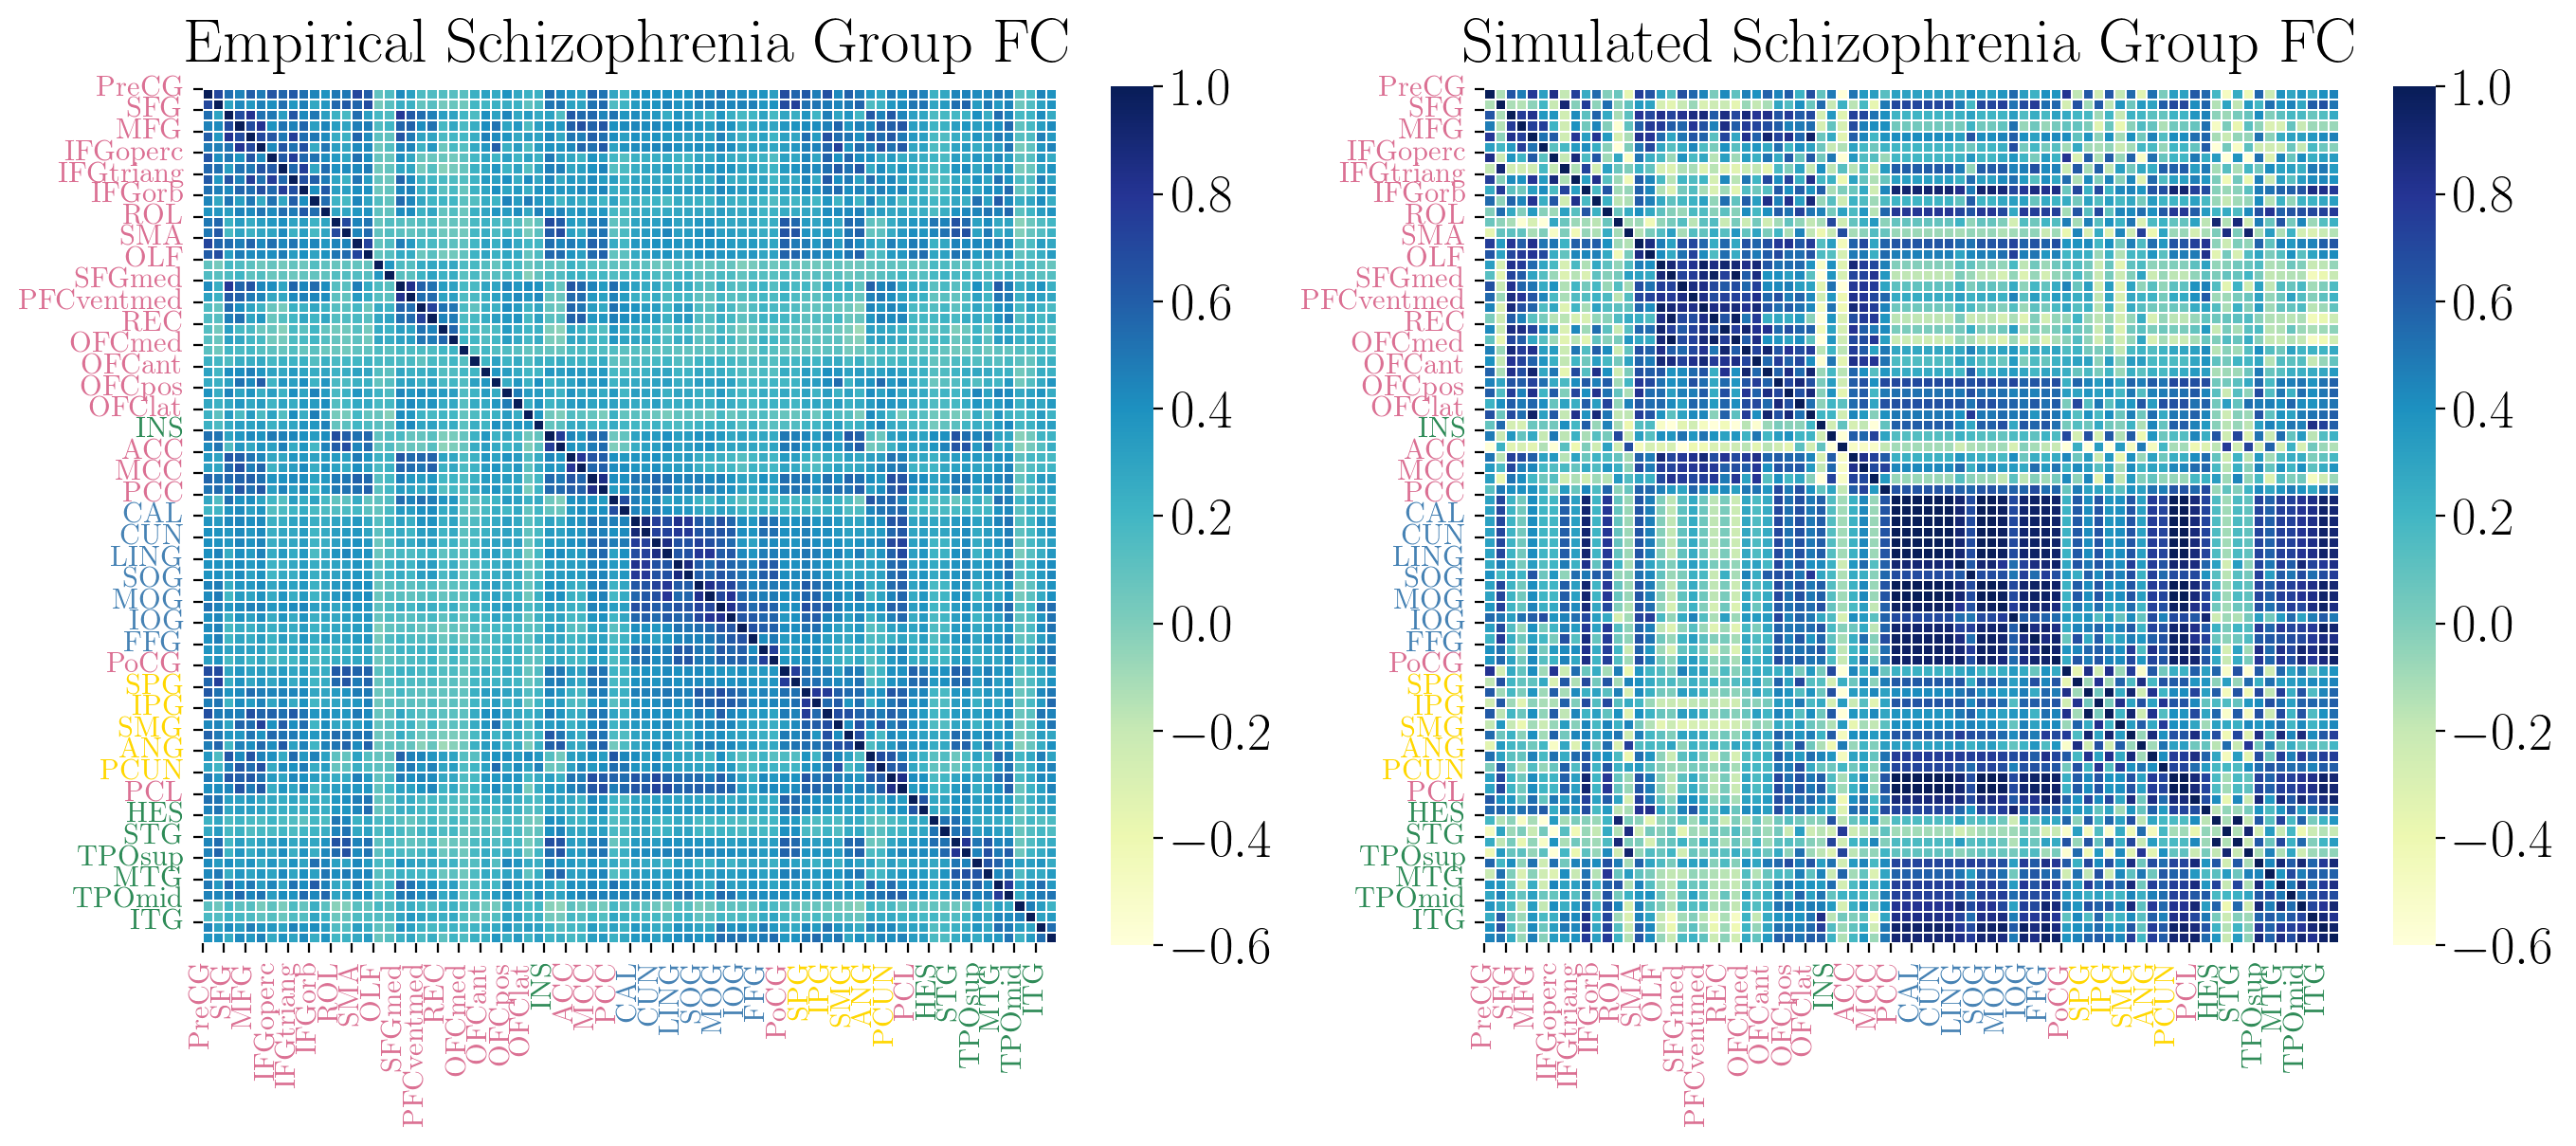

In [28]:
import neurolib.utils.functions as func

# Plot Empirical and simulated connectivity matrix
fig, ax = plt.subplots(1,2, figsize=(16,10))
fig.set_facecolor('w') 
sns.heatmap(FCs_scz, square=True, ax=ax[0], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .6}, vmin=-0.6, vmax=1)
ax[0].set_title('Empirical Schizophrenia Group FC',pad=10,  size=24);
sns.heatmap(func.fc(wc_scz.BOLD.BOLD[:, wc_scz.BOLD.t_BOLD>10000]), square=True, ax=ax[1], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .6},vmin=-0.6, vmax=1)
ax[1].set_title('Simulated Schizophrenia Group FC',pad=10,  size=24);
ticks = [tick[:-2] for tick in emp_labels[::2]]
for axs in ax:
    axs.set_xticks(np.arange(0,80,2)); axs.set_yticks(np.arange(0,80,2))    
    axs.set_xticklabels(ticks, rotation=90, fontsize=11); axs.set_yticklabels(ticks, rotation=0, fontsize=11);
    
ax[0].get_xticklabels()[0].set_color("palevioletred")
ax[0].get_xticklabels()[1].set_color("palevioletred")
ax[0].get_xticklabels()[2].set_color("palevioletred")
ax[0].get_xticklabels()[3].set_color("palevioletred")
ax[0].get_xticklabels()[4].set_color("palevioletred")
ax[0].get_xticklabels()[5].set_color("palevioletred")
ax[0].get_xticklabels()[6].set_color("palevioletred")
ax[0].get_xticklabels()[7].set_color("palevioletred")
ax[0].get_xticklabels()[8].set_color("palevioletred")
ax[0].get_xticklabels()[9].set_color("palevioletred")
ax[0].get_xticklabels()[10].set_color("palevioletred")
ax[0].get_xticklabels()[11].set_color("palevioletred")
ax[0].get_xticklabels()[12].set_color("palevioletred")
ax[0].get_xticklabels()[13].set_color("palevioletred")
ax[0].get_xticklabels()[14].set_color("palevioletred")
ax[0].get_xticklabels()[15].set_color("palevioletred")
ax[0].get_xticklabels()[17].set_color("palevioletred")
ax[0].get_xticklabels()[18].set_color("palevioletred")
ax[0].get_xticklabels()[19].set_color("palevioletred")
ax[0].get_xticklabels()[27].set_color("palevioletred")
ax[0].get_xticklabels()[33].set_color("palevioletred")
ax[0].get_yticklabels()[0].set_color("palevioletred")
ax[0].get_yticklabels()[1].set_color("palevioletred")
ax[0].get_yticklabels()[2].set_color("palevioletred")
ax[0].get_yticklabels()[3].set_color("palevioletred")
ax[0].get_yticklabels()[4].set_color("palevioletred")
ax[0].get_yticklabels()[5].set_color("palevioletred")
ax[0].get_yticklabels()[6].set_color("palevioletred")
ax[0].get_yticklabels()[7].set_color("palevioletred")
ax[0].get_yticklabels()[8].set_color("palevioletred")
ax[0].get_yticklabels()[9].set_color("palevioletred")
ax[0].get_yticklabels()[10].set_color("palevioletred")
ax[0].get_yticklabels()[11].set_color("palevioletred")
ax[0].get_yticklabels()[12].set_color("palevioletred")
ax[0].get_yticklabels()[13].set_color("palevioletred")
ax[0].get_yticklabels()[14].set_color("palevioletred")
ax[0].get_yticklabels()[15].set_color("palevioletred")
ax[0].get_yticklabels()[17].set_color("palevioletred")
ax[0].get_yticklabels()[18].set_color("palevioletred")
ax[0].get_yticklabels()[19].set_color("palevioletred")
ax[0].get_yticklabels()[27].set_color("palevioletred")
ax[0].get_yticklabels()[33].set_color("palevioletred")

ax[0].get_xticklabels()[16].set_color("seagreen")
ax[0].get_xticklabels()[34].set_color("seagreen")
ax[0].get_xticklabels()[35].set_color("seagreen")
ax[0].get_xticklabels()[36].set_color("seagreen")
ax[0].get_xticklabels()[37].set_color("seagreen")
ax[0].get_xticklabels()[38].set_color("seagreen")
ax[0].get_xticklabels()[39].set_color("seagreen")

ax[0].get_yticklabels()[16].set_color("seagreen")
ax[0].get_yticklabels()[34].set_color("seagreen")
ax[0].get_yticklabels()[35].set_color("seagreen")
ax[0].get_yticklabels()[36].set_color("seagreen")
ax[0].get_yticklabels()[37].set_color("seagreen")
ax[0].get_yticklabels()[38].set_color("seagreen")
ax[0].get_yticklabels()[39].set_color("seagreen")

ax[0].get_xticklabels()[20].set_color("steelblue")
ax[0].get_xticklabels()[21].set_color("steelblue")
ax[0].get_xticklabels()[22].set_color("steelblue")
ax[0].get_xticklabels()[23].set_color("steelblue")
ax[0].get_xticklabels()[24].set_color("steelblue")
ax[0].get_xticklabels()[25].set_color("steelblue")
ax[0].get_xticklabels()[26].set_color("steelblue")

ax[0].get_yticklabels()[20].set_color("steelblue")
ax[0].get_yticklabels()[21].set_color("steelblue")
ax[0].get_yticklabels()[22].set_color("steelblue")
ax[0].get_yticklabels()[23].set_color("steelblue")
ax[0].get_yticklabels()[24].set_color("steelblue")
ax[0].get_yticklabels()[25].set_color("steelblue")
ax[0].get_yticklabels()[26].set_color("steelblue")

ax[0].get_xticklabels()[28].set_color("gold")
ax[0].get_xticklabels()[29].set_color("gold")
ax[0].get_xticklabels()[30].set_color("gold")
ax[0].get_xticklabels()[31].set_color("gold")
ax[0].get_xticklabels()[32].set_color("gold")

ax[0].get_yticklabels()[28].set_color("gold")
ax[0].get_yticklabels()[29].set_color("gold")
ax[0].get_yticklabels()[30].set_color("gold")
ax[0].get_yticklabels()[31].set_color("gold")
ax[0].get_yticklabels()[32].set_color("gold")
    
    
ax[1].get_xticklabels()[0].set_color("palevioletred")
ax[1].get_xticklabels()[1].set_color("palevioletred")
ax[1].get_xticklabels()[2].set_color("palevioletred")
ax[1].get_xticklabels()[3].set_color("palevioletred")
ax[1].get_xticklabels()[4].set_color("palevioletred")
ax[1].get_xticklabels()[5].set_color("palevioletred")
ax[1].get_xticklabels()[6].set_color("palevioletred")
ax[1].get_xticklabels()[7].set_color("palevioletred")
ax[1].get_xticklabels()[8].set_color("palevioletred")
ax[1].get_xticklabels()[9].set_color("palevioletred")
ax[1].get_xticklabels()[10].set_color("palevioletred")
ax[1].get_xticklabels()[11].set_color("palevioletred")
ax[1].get_xticklabels()[12].set_color("palevioletred")
ax[1].get_xticklabels()[13].set_color("palevioletred")
ax[1].get_xticklabels()[14].set_color("palevioletred")
ax[1].get_xticklabels()[15].set_color("palevioletred")
ax[1].get_xticklabels()[17].set_color("palevioletred")
ax[1].get_xticklabels()[18].set_color("palevioletred")
ax[1].get_xticklabels()[19].set_color("palevioletred")
ax[1].get_xticklabels()[27].set_color("palevioletred")
ax[1].get_xticklabels()[33].set_color("palevioletred")
ax[1].get_yticklabels()[0].set_color("palevioletred")
ax[1].get_yticklabels()[1].set_color("palevioletred")
ax[1].get_yticklabels()[2].set_color("palevioletred")
ax[1].get_yticklabels()[3].set_color("palevioletred")
ax[1].get_yticklabels()[4].set_color("palevioletred")
ax[1].get_yticklabels()[5].set_color("palevioletred")
ax[1].get_yticklabels()[6].set_color("palevioletred")
ax[1].get_yticklabels()[7].set_color("palevioletred")
ax[1].get_yticklabels()[8].set_color("palevioletred")
ax[1].get_yticklabels()[9].set_color("palevioletred")
ax[1].get_yticklabels()[10].set_color("palevioletred")
ax[1].get_yticklabels()[11].set_color("palevioletred")
ax[1].get_yticklabels()[12].set_color("palevioletred")
ax[1].get_yticklabels()[13].set_color("palevioletred")
ax[1].get_yticklabels()[14].set_color("palevioletred")
ax[1].get_yticklabels()[15].set_color("palevioletred")
ax[1].get_yticklabels()[17].set_color("palevioletred")
ax[1].get_yticklabels()[18].set_color("palevioletred")
ax[1].get_yticklabels()[19].set_color("palevioletred")
ax[1].get_yticklabels()[27].set_color("palevioletred")
ax[1].get_yticklabels()[33].set_color("palevioletred")

ax[1].get_xticklabels()[16].set_color("seagreen")
ax[1].get_xticklabels()[34].set_color("seagreen")
ax[1].get_xticklabels()[35].set_color("seagreen")
ax[1].get_xticklabels()[36].set_color("seagreen")
ax[1].get_xticklabels()[37].set_color("seagreen")
ax[1].get_xticklabels()[38].set_color("seagreen")
ax[1].get_xticklabels()[39].set_color("seagreen")

ax[1].get_yticklabels()[16].set_color("seagreen")
ax[1].get_yticklabels()[34].set_color("seagreen")
ax[1].get_yticklabels()[35].set_color("seagreen")
ax[1].get_yticklabels()[36].set_color("seagreen")
ax[1].get_yticklabels()[37].set_color("seagreen")
ax[1].get_yticklabels()[38].set_color("seagreen")
ax[1].get_yticklabels()[39].set_color("seagreen")

ax[1].get_xticklabels()[20].set_color("steelblue")
ax[1].get_xticklabels()[21].set_color("steelblue")
ax[1].get_xticklabels()[22].set_color("steelblue")
ax[1].get_xticklabels()[23].set_color("steelblue")
ax[1].get_xticklabels()[24].set_color("steelblue")
ax[1].get_xticklabels()[25].set_color("steelblue")
ax[1].get_xticklabels()[26].set_color("steelblue")

ax[1].get_yticklabels()[20].set_color("steelblue")
ax[1].get_yticklabels()[21].set_color("steelblue")
ax[1].get_yticklabels()[22].set_color("steelblue")
ax[1].get_yticklabels()[23].set_color("steelblue")
ax[1].get_yticklabels()[24].set_color("steelblue")
ax[1].get_yticklabels()[25].set_color("steelblue")
ax[1].get_yticklabels()[26].set_color("steelblue")

ax[1].get_xticklabels()[28].set_color("gold")
ax[1].get_xticklabels()[29].set_color("gold")
ax[1].get_xticklabels()[30].set_color("gold")
ax[1].get_xticklabels()[31].set_color("gold")
ax[1].get_xticklabels()[32].set_color("gold")

ax[1].get_yticklabels()[28].set_color("gold")
ax[1].get_yticklabels()[29].set_color("gold")
ax[1].get_yticklabels()[30].set_color("gold")
ax[1].get_yticklabels()[31].set_color("gold")
ax[1].get_yticklabels()[32].set_color("gold")